# Notes

This notebook works through an example using the iris module to load and plot UK winter mean precipitation from CANARI-LE historical data.

Main iris webpage https://scitools.org.uk/iris/docs/latest

There's a full documentation there, but it's definitely worth workinthrough the 'User Guide' section which explains a lot of the concepts.

The four main iris objects are

- `iris.cube.Cube` holds the data array for a single variable, along with metadata including the variable name, its units and its coordinates. The main building block of iris.
- `iris.cube.CubeList` is like a list of Cubes, but with extra methods which let you process multiples cubes at once.
- `iris.coords.DimCoord` and `iris.coords.AuxCoord` hold the data and metadata for cube coordinates. There's two types: a `DimCoord` must be a mononic 1-d array, whereas an `AuxCoord` can be multi-dimensional and/or non-monotonic.
- `iris.Constraint` allow intelligent subsetting of a `Cube` or `Cubelist` without needing to use array indices etc.


In [1]:
import glob
import warnings
import numpy as np
import datetime
import iris
import iris.coord_categorisation as icc
import iris.quickplot as qplt
import matplotlib.pyplot as plt

In [2]:
# First, define a function to load all the yearly files for a single member and merge them into a single cube.
def load_hist_single(mem, varname, con=None, years=range(1950, 2015)):
    """
    Load selected years for a single variable for a single historical member
    and concatenate into a single cube.

    Args
    ----
      mem (int): Ensemble member number.
      varname (str): My shorthand variable names. Mapping to LE file names defined in varname_map below.
      con (optional, iris.Constraint): Constraint to apply at load time.
      years (optional, iterable): Years to load. Default is full historical period (1950-2014).
    """
    varname_map = {'monthly_precip': 'mon_m01s05i216_3'}
    ledir = '/gws/nopw/j04/canari/shared/large-ensemble'
    fns = [glob.glob('{0}/priority/HIST2/{1}/ATM/yearly/{2}/??????_{1}_{3}.nc'.\
                     format(ledir, mem, year, varname_map[varname]))[0] for year in years]
    print('Loading files:\n{}'.format('\n'.join(fns)))
    
    def _add_realization_coord(cube, field, filename):
        # Callback function to add realization (i.e. ens member) AuxCoord at load time
        # This is useful for merging members into a multi-dimensional cube later.
        rco = iris.coords.DimCoord(int(cube.attributes['realization_index']),
                                   long_name='realization_index')
        cube.add_aux_coord(rco)
    
    # Load data but hide UserWarning about cellarea
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        cl = iris.load(fns, con, callback=_add_realization_coord)

    # Remove any attribute data that does not match between cubes, to allow concatenation
    iris.util.equalise_attributes(cl)

    # Return a single cube holding all the data
    return cl.concatenate_cube()

In [3]:
# Next, load the monthly mean precipitation rate for member 1 only
prmon = load_hist_single(1, 'monthly_precip')

Loading files:
/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1/ATM/yearly/1950/cv575a_1_mon_m01s05i216_3.nc
/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1/ATM/yearly/1951/cv575a_1_mon_m01s05i216_3.nc
/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1/ATM/yearly/1952/cv575a_1_mon_m01s05i216_3.nc
/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1/ATM/yearly/1953/cv575a_1_mon_m01s05i216_3.nc
/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1/ATM/yearly/1954/cv575a_1_mon_m01s05i216_3.nc
/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1/ATM/yearly/1955/cv575a_1_mon_m01s05i216_3.nc
/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1/ATM/yearly/1956/cv575a_1_mon_m01s05i216_3.nc
/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1/ATM/yearly/1957/cv575a_1_mon_m01s05i216_3.nc
/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1/ATM/yearly/1958/cv575a_1_mon_m01s05i216_3.nc
/gws/nopw/j04/canari/shared/large-ensemb

In [4]:
# Define a function to convert precip units to mm/day of liquid water equivalent
def convert_pr_units(cube):
    density_lw = iris.coords.DimCoord(1000.0, units='kg m-3')
    name = cube.name()
    cube = cube / density_lw
    cube.convert_units('mm day-1')
    cube.rename(name)
    return cube

In [5]:
prmon = convert_pr_units(prmon)

In [6]:
# Define a function to use season and season_year auxiliary coords to compute means for each DJF season
def calc_seas_mean(cube, season='djf'):
    
    # Add season and season_year AuxCoords if not already present
    print('Computing {} mean of {}'.format(season, cube.name()))
    conames = [co.name() for co in cube.coords()]
    if 'season' not in conames: icc.add_season(cube, 'time')
    if 'season_year' not in conames: icc.add_season_year(cube, 'time')
        
    # Extract only months in season and then take the mean for each season_year
    cube_seas = cube.extract(iris.Constraint(season=season)).aggregated_by(['season', 'season_year'], iris.analysis.MEAN)
    
    # Remove any seasons less than 90 days (i.e the incomplete first and last for DJF)
    tc = cube_seas.coord('time')
    seaslens = np.array([tc.units.num2date(b[1]) - tc.units.num2date(b[0]) for b in tc.bounds])
    bad_times = tc.units.num2date(tc.points[seaslens < datetime.timedelta(days=90)])
    cube_seas_trim = cube_seas.extract(iris.Constraint(time=lambda t: t.point not in bad_times))
    if len(tc.points) > len(cube_seas_trim.coord('time').points):
        print('Trimming incomplete seasons:')
        print(bad_times)
    return cube_seas_trim

In [7]:
prdjf = calc_seas_mean(prmon, season='djf')

Computing djf mean of precipitation_flux
Trimming incomplete seasons:
[cftime.Datetime360Day(1950, 2, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.Datetime360Day(2014, 12, 16, 0, 0, 0, 0, has_year_zero=True)]


In [8]:
# Subset to box around the UK
pruk = prdjf.intersection(longitude=[-12, 3], latitude=[46, 61])

/gws/smf/j04/canari/conda-env/lib/python3.10/site-packages/iris/coords.py:2164: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(
/gws/smf/j04/canari/conda-env/lib/python3.10/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'season_year', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'season_year'. Ignoring bounds.
  warnings.warn(


/gws/smf/j04/canari/conda-env/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


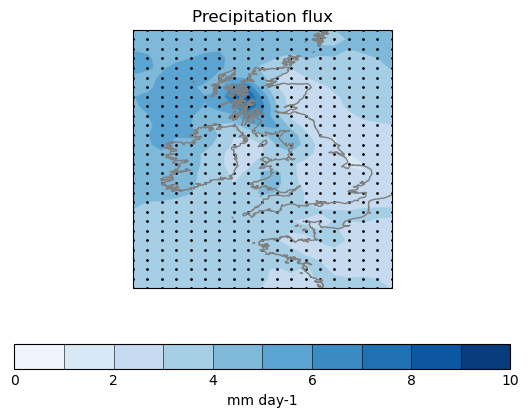

In [9]:
# Plot climatology
# Note: iris.quickplot contains useful functions for creating simple plots quickly (uses cube meta data to label etc)
#       iris.plot allows more control
# Both are built on matplotlib and cartopy.
qplt.contourf(pruk.collapsed('time', iris.analysis.MEAN), levels=np.arange(0, 11), cmap='Blues')
plt.gca().coastlines(color='0.5') # Add coastline
qplt.points(pruk[0], s=1, c='k')  # Add model grid points for reference

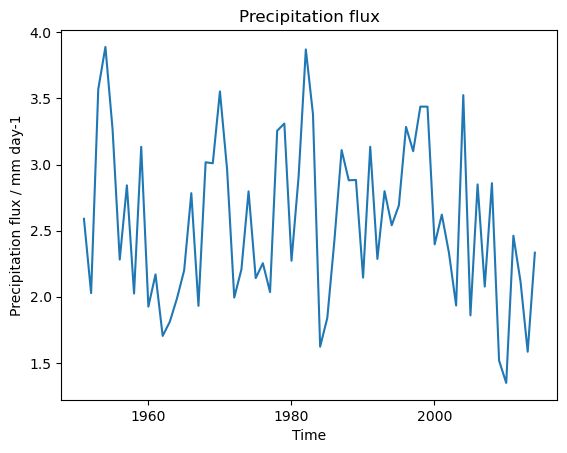

In [10]:
# Plot yearly timeseries for nearest grid point to London
london_lon = 0.0
london_lat = 51.5
prlondon = pruk.interpolate([('longitude', london_lon), ('latitude', london_lat)], iris.analysis.Nearest())
qplt.plot(prlondon)

In [11]:
# Repeat for multiple members.
# Apply area constraint at load time to reduce memory needed
mems = [1, 2, 3, 4, 5]
ukcon = iris.Constraint(longitude=lambda lon: lon>=350 or lon<=2, latitude=lambda lat: 50<=lat<=60)
pr_cubes = iris.cube.CubeList([load_hist_single(mem, 'monthly_precip', con=ukcon, years=range(1950, 1971)) for mem in mems])

Loading files:
/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1/ATM/yearly/1950/cv575a_1_mon_m01s05i216_3.nc
/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1/ATM/yearly/1951/cv575a_1_mon_m01s05i216_3.nc
/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1/ATM/yearly/1952/cv575a_1_mon_m01s05i216_3.nc
/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1/ATM/yearly/1953/cv575a_1_mon_m01s05i216_3.nc
/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1/ATM/yearly/1954/cv575a_1_mon_m01s05i216_3.nc
/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1/ATM/yearly/1955/cv575a_1_mon_m01s05i216_3.nc
/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1/ATM/yearly/1956/cv575a_1_mon_m01s05i216_3.nc
/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1/ATM/yearly/1957/cv575a_1_mon_m01s05i216_3.nc
/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1/ATM/yearly/1958/cv575a_1_mon_m01s05i216_3.nc
/gws/nopw/j04/canari/shared/large-ensemb

In [12]:
# Merge into a single cube with realization_index as a new dimension
iris.util.equalise_attributes(pr_cubes)
prmon = pr_cubes.merge_cube()
print(prmon)

precipitation_flux / (kg m-2 s-1)   (realization_index: 5; time: 252; latitude: 20; longitude: 16)
    Dimension coordinates:
        realization_index                             x        -              -              -
        time                                          -        x              -              -
        latitude                                      -        -              x              -
        longitude                                     -        -              -              x
    Cell methods:
        0                           area: mean
        1                           time: mean (interval: 900 s)
    Attributes:
        Conventions                 'CF-1.10'
        activity_id                 'CANARI-LE'
        branch_method               'micro perturbation (atmosphere stochastic physics random seed) of parent ...'
        branch_time_in_child        '1950'
        branch_time_in_parent       '1950'
        contact                     ''
        descri

Computing djf mean of precipitation_flux
Trimming incomplete seasons:
[cftime.Datetime360Day(1950, 2, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.Datetime360Day(1970, 12, 16, 0, 0, 0, 0, has_year_zero=True)]


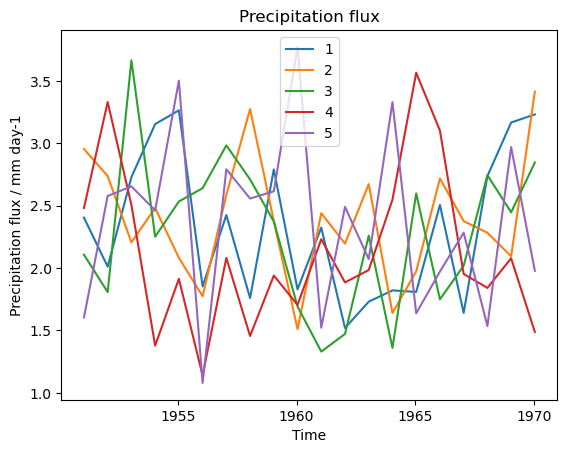

In [13]:
# Interpolate to nearest gridpoint to London, convert to mm/day and cmopute DJF means
prlondon = prmon.interpolate([('longitude', london_lon), ('latitude', london_lat)], iris.analysis.Nearest())
prlondon = convert_pr_units(prlondon)
prlondon = calc_seas_mean(prlondon, season='djf')
# Plot line plot for each member
for prlondon_mem in prlondon.slices_over('realization_index'):
    qplt.plot(prlondon_mem, label=prlondon_mem.coord('realization_index').points[0])
plt.legend()